Over Sample and undersample? Bootstrap? repeated holdout? Stratefied k Fold Scikit learn has weights feature

We are interested in precision for no default, recall for default

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('DefaultCreditcardClients.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)

#Create a separate dataset with only useful variables as identified in Lab1 and Mini-lab1.
dfsub = df.loc[:,['SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','default','log_LIMIT_BAL','log_PAY_AMT1','log_PAY_AMT2','log_PAY_AMT3','log_PAY_AMT4','log_PAY_AMT5','log_PAY_AMT6']]

We found in Lab1 that there is high correlation between BILL Amount and Pay so we ignored them

In [2]:
dfsub.head()

,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default,log_LIMIT_BAL,log_PAY_AMT1,log_PAY_AMT2,log_PAY_AMT3,log_PAY_AMT4,log_PAY_AMT5,log_PAY_AMT6
ID,,,,,,,,,,,,,,,,,,
1,2,2,1,24,2,2,-1,-1,-2,-2,1,9.903488,0.000000,6.536692,0.000000,0.000000,0.000000,0.000000
2,2,2,2,26,-1,2,0,0,0,2,1,11.695247,0.000000,6.908755,6.908755,6.908755,0.000000,7.601402
3,2,2,2,34,0,0,0,0,0,0,0,11.407565,7.325808,7.313887,6.908755,6.908755,6.908755,8.517393
4,2,2,1,37,0,0,0,0,0,0,0,10.819778,7.601402,7.610853,7.090910,7.003974,6.975414,6.908755
5,1,2,1,57,-1,0,-1,0,0,0,0,10.819778,7.601402,10.510041,9.210440,9.105091,6.536692,6.522093


## Random Forests for Payment Default Analysis

Number of Observations 30000


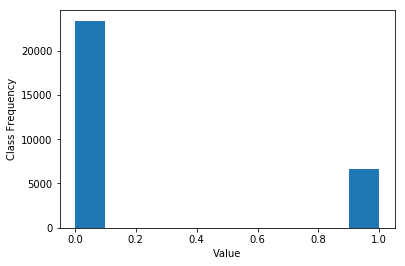

In [3]:
print ('Number of Observations', len(dfsub.default))

from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(dfsub.default )
plt.xlabel('Value')
plt.ylabel('Class Frequency')
plt.show()

In [4]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()

Accuracy 0.8174333333333333


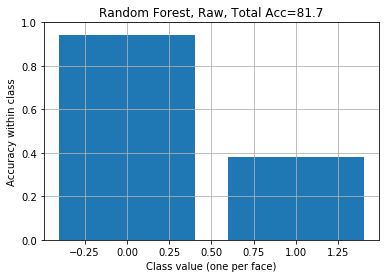

Wall time: 17.3 s


In [5]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn import metrics as mt

# create variables we are more familiar with
if 'default' in dfsub:
    y = dfsub['default'].values
    del dfsub['default'] 
    X = dfsub.values
    yhat = np.zeros(y.shape) # we will fill this with predictions
    
cv = StratifiedKFold(n_splits=10)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")


#https://www.youtube.com/watch?v=DQC_YE3I5ig

Trial and error with different estimators yielded simmilar results:  
Estimators = Accuracy  
1000=81%   
400 = 81.7%   
200 = 81.8%   
20 = 81.1% 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


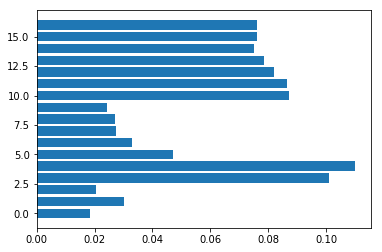

Generalization score estimate from training data 0.8153031369208548


In [6]:
print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)

Try 100 splits  
Accuracy = 0.8162666666666667

Accuracy 0.8173333333333334


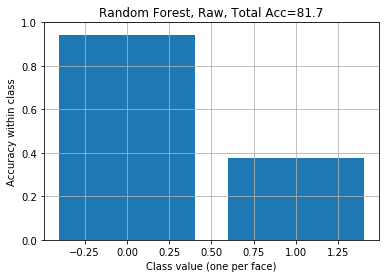

Wall time: 3min 6s


In [7]:
%%time
cv = StratifiedKFold(n_splits=100)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")
#1000 81
#400 = 81.7
#200 = 81.8
#20 = 81.1

#https://www.youtube.com/watch?v=DQC_YE3I5ig

Try Balanced Subsample  
Accuracy 0.8170333333333333

Accuracy 0.8168666666666666


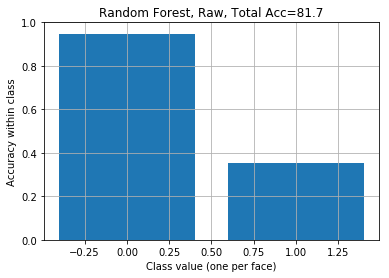

Wall time: 20.7 s


In [8]:
%%time
cv = StratifiedKFold(n_splits=10)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(class_weight='balanced_subsample',max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")

#https://www.youtube.com/watch?v=DQC_YE3I5ig
#balanced_subsample' = 81.7

Try different weights  
Accuracy 0.8153666666666667

Accuracy 0.8146


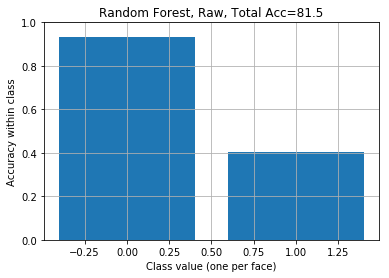

Wall time: 18.1 s


In [9]:
%%time
weights ={1:.1, 0: .9}
cv = StratifiedKFold(n_splits=10)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(class_weight=weights,max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")
#weights ={1:.1, 0: .9} = 81.4

#https://www.youtube.com/watch?v=DQC_YE3I5ig

## Random Forests for Education Analysis

In [10]:
dfsub[['EDUCATION']].describe()

,EDUCATION
count,30000.000000
mean,1.842267
std,0.744494
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,4.000000


Categorize observations into categories "College" and "High School"

 - EDUCATION
     - 1 = Graduate School
     - 2 = University
     - 3 = High School
     - 4 = Other

In [21]:
dfsub['College'] = np.where(dfsub['EDUCATION']<3, 1, 0)
print(dfsub[0:50])

    SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  \
ID                                                                            
1     2          2         1   24      2      2     -1     -1     -2     -2   
2     2          2         2   26     -1      2      0      0      0      2   
3     2          2         2   34      0      0      0      0      0      0   
4     2          2         1   37      0      0      0      0      0      0   
5     1          2         1   57     -1      0     -1      0      0      0   
6     1          1         2   37      0      0      0      0      0      0   
7     1          1         2   29      0      0      0      0      0      0   
8     2          2         2   23      0     -1     -1      0      0     -1   
9     2          3         1   28      0      0      2      0      0      0   
10    1          3         2   35     -2     -2     -2     -2     -1     -1   
11    2          3         2   34      0      0     

Accuracy 0.8189666666666666


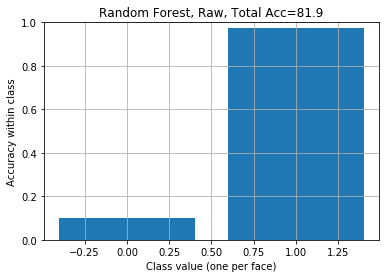

Wall time: 15.8 s


In [22]:
%%time
# create variables we are more familiar with
if 'College' in dfsub:
    y = dfsub['College'].values
    del dfsub['College'] 
    del dfsub['EDUCATION'] 
    X = dfsub.values
    yhat = np.zeros(y.shape) # we will fill this with predictions
    
cv = StratifiedKFold(n_splits=10)
scl = StandardScaler()
X = scl.fit_transform(X)

clf = RandomForestClassifier(max_depth=50, n_estimators=200, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(y,yhat,title="Random Forest, Raw")